In [12]:
library(arules)
library(ggplot2)
library(recommenderlab)

# 14.1 关联规则

e.g.1:手机保护壳交易数据库中的关联规则

In [13]:
fp.df <- read.csv("Data/Faceplate.csv")

fp.mat <- as.matrix(fp.df[, -1])
fp.trans <- as(fp.mat, "transactions")
inspect(fp.trans)

     items                    
[1]  {Red, White, Green}      
[2]  {White, Orange}          
[3]  {White, Blue}            
[4]  {Red, White, Orange}     
[5]  {Red, Blue}              
[6]  {White, Blue}            
[7]  {Red, Blue}              
[8]  {Red, White, Blue, Green}
[9]  {Red, White, Blue}       
[10] {Yellow}                 


In [14]:
rules <- apriori(fp.trans, parameter = list(support = 0.2, confidence = 0.5, target = "rules"))
inspect(head(sort(rules, by = "lift"), n = 6))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5     0.2      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 2 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[6 item(s), 10 transaction(s)] done [0.00s].
sorting and recoding items ... [5 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [18 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
    lhs               rhs     support confidence coverage lift     count
[1] {Red, White}   => {Green} 0.2     0.5        0.4      2.500000 2    
[2] {Green}        => {Red}   0.2     1.0        0.2      1.666667 2    
[3] {White, Green} => {Red}   0.2     1.0        0.2      1.666667 2    
[4]

e.g.2:图书购买交易数据库中的关联规则

In [15]:
book_df <- read.csv("Data/CharlesBookClub.csv")

count_book_df <- book_df[, 8:18]
incid_book_df <- ifelse(count_book_df > 0, 1, 0)
incid_book_mat <- as.matrix(incid_book_df[, -1])

books_trans <- as(incid_book_mat, "transactions")
inspect(head((books_trans),n = 15))

     items                                         
[1]  {YouthBks, CookBks}                           
[2]  {}                                            
[3]  {YouthBks, CookBks, RefBks, GeogBks, ItalCook}
[4]  {}                                            
[5]  {}                                            
[6]  {}                                            
[7]  {GeogBks}                                     
[8]  {}                                            
[9]  {}                                            
[10] {CookBks}                                     
[11] {CookBks}                                     
[12] {ArtBks, Florence}                            
[13] {Florence}                                    
[14] {}                                            
[15] {}                                            


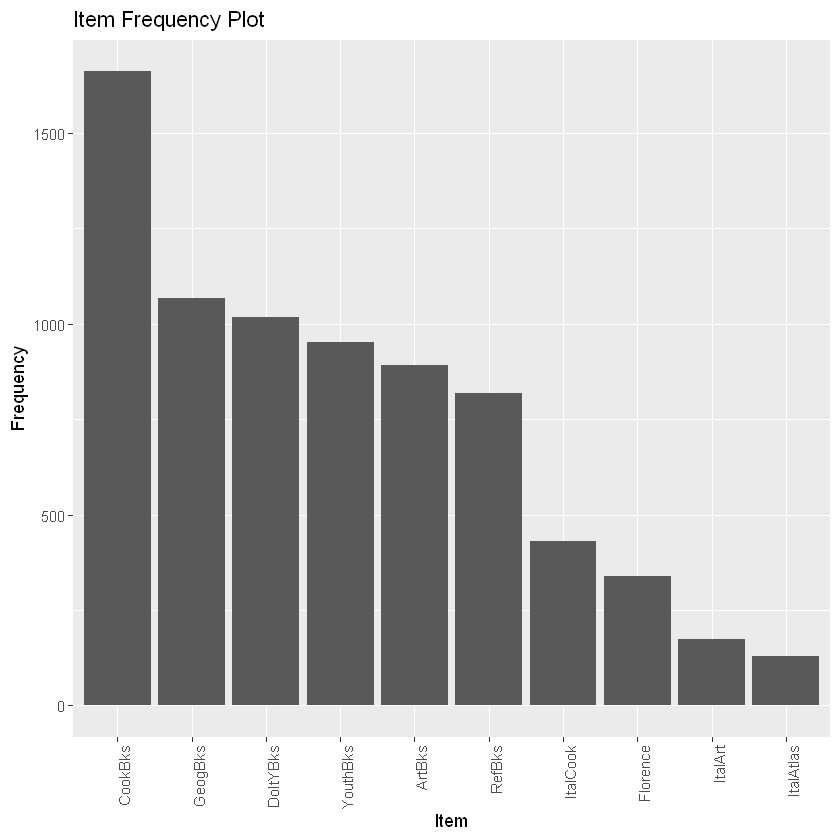

In [16]:
item_freq <- itemFrequency(books_trans, type = "absolute")
item_freq_df <- data.frame(
  item = names(item_freq),
  frequency = item_freq
)

ggplot(item_freq_df, aes(x = reorder(item, -frequency), y = frequency)) +
  geom_bar(stat = "identity") +xlab("Item") +ylab("Frequency") +ggtitle("Item Frequency Plot") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [17]:
rules <- apriori(books_trans, parameter = list(supp = 200/4000, conf = 0.5, target = "rules"))
inspect(head(sort(rules, by = "lift"), n = 6))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.05      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 200 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[10 item(s), 4000 transaction(s)] done [0.00s].
sorting and recoding items ... [8 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [21 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
    lhs                    rhs        support confidence coverage lift    
[1] {DoItYBks, GeogBks} => {YouthBks} 0.05450 0.5396040  0.10100  2.264864
[2] {CookBks, GeogBks}  => {YouthBks} 0.08025 0.5136000  0.15625  2.155719
[3] {CookBks, RefBks}   => {DoItYBks} 0.07450 0.5330948  0.1397

# 14.2 协同过滤

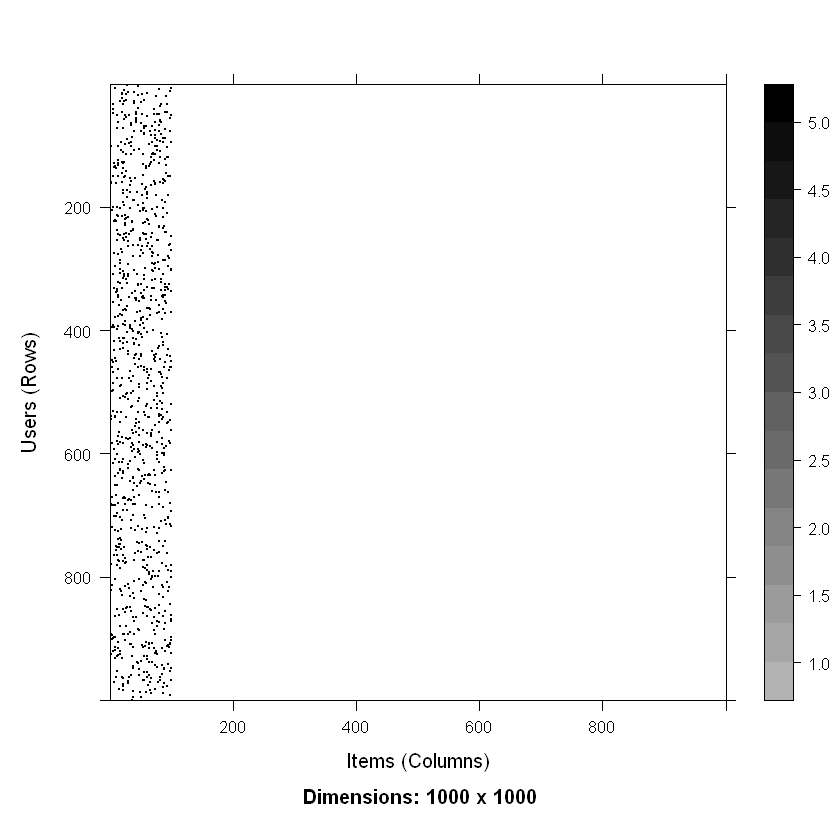

In [18]:
m <- matrix(nrow = 1000, ncol = 1000)
m[sample.int(100*1000, 1000)] <- ceiling(runif(1000, 0, 5))
r <- as(m, "realRatingMatrix")
image(r)

In [19]:
UB.Rec <- Recommender(r, method = "UBCF")
pred <- predict(UB.Rec, r, type="ratings")
# as(pred, "matrix")